Lambda School Data Science

*Unit 2, Sprint 3, Module 1*

---


# Define ML problems

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your decisions.

- [ ] Choose your target. Which column in your tabular dataset will you predict?
- [ ] Is your problem regression or classification?
- [ ] How is your target distributed?
    - Classification: How many classes? Are the classes imbalanced?
    - Regression: Is the target right-skewed? If so, you may want to log transform the target.
- [ ] Choose your evaluation metric(s).
    - Classification: Is your majority class frequency >= 50% and < 70% ? If so, you can just use accuracy if you want. Outside that range, accuracy could be misleading. What evaluation metric will you choose, in addition to or instead of accuracy?
    - Regression: Will you use mean absolute error, root mean squared error, R^2, or other regression metrics?
- [ ] Choose which observations you will use to train, validate, and test your model.
    - Are some observations outliers? Will you exclude them?
    - Will you do a random split or a time-based split?
- [ ] Begin to clean and explore your data.
- [ ] Begin to choose which features, if any, to exclude. Would some features "leak" future information?

If you haven't found a dataset yet, do that today. [Review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2) and choose your dataset.

Some students worry, ***what if my model isn't “good”?*** Then, [produce a detailed tribute to your wrongness. That is science!](https://twitter.com/nathanwpyle/status/1176860147223867393)

In [1]:
%%capture

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
rainier = pd.read_csv('../data/climbing_statistics.csv')
rainier_weather = pd.read_csv('../data/Rainier_Weather.csv')
print(rainier.shape)
print(rainier_weather.shape)

(4077, 5)
(464, 7)


In [3]:
rainier.head()

,Date,Route,Attempted,Succeeded,Success Percentage
0,11/27/2015,Disappointment Cleaver,2,0,0.0
1,11/21/2015,Disappointment Cleaver,3,0,0.0
2,10/15/2015,Disappointment Cleaver,2,0,0.0
3,10/13/2015,Little Tahoma,8,0,0.0
4,10/9/2015,Disappointment Cleaver,2,0,0.0


In [4]:
rainier.tail()

,Date,Route,Attempted,Succeeded,Success Percentage
4072,1/16/2014,Little Tahoma,2,0,0.000000
4073,1/6/2014,Disappointment Cleaver,8,0,0.000000
4074,1/6/2014,Disappointment Cleaver,8,0,0.000000
4075,1/5/2014,Disappointment Cleaver,2,0,0.000000
4076,1/4/2014,Gibralter Ledges,3,2,0.666667


In [5]:
rainier_weather.head()

,Date,Battery Voltage AVG,Temperature AVG,Relative Humidity AVG,Wind Speed Daily AVG,Wind Direction AVG,Solare Radiation AVG
0,12/31/2015,13.845000,19.062917,21.870833,21.977792,62.325833,84.915292
1,12/30/2015,13.822917,14.631208,18.493833,3.540542,121.505417,86.192833
2,12/29/2015,13.834583,6.614292,34.072917,0.000000,130.291667,85.100917
3,12/28/2015,13.710417,8.687042,70.557917,0.000000,164.683750,86.241250
4,12/27/2015,13.362500,14.140417,95.754167,0.000000,268.479167,31.090708


In [6]:
rainier_weather.tail()

,Date,Battery Voltage AVG,Temperature AVG,Relative Humidity AVG,Wind Speed Daily AVG,Wind Direction AVG,Solare Radiation AVG
459,9/27/2014,13.467083,33.318750,60.200417,7.140917,116.294583,227.597125
460,9/26/2014,13.532500,28.238333,100.000000,0.897625,259.645833,114.400833
461,9/25/2014,13.648333,26.823750,99.854167,3.166208,278.604167,142.698917
462,9/24/2014,13.168750,29.702917,100.000000,45.915000,278.054167,37.873708
463,9/23/2014,13.056667,32.857333,100.000000,65.110667,254.273333,16.593800


In [7]:
rainier.dtypes

Date                   object
Route                  object
Attempted               int64
Succeeded               int64
Success Percentage    float64
dtype: object

In [8]:
rainier_weather.dtypes

Date                      object
Battery Voltage AVG      float64
Temperature AVG          float64
Relative Humidity AVG    float64
Wind Speed Daily AVG     float64
Wind Direction AVG       float64
Solare Radiation AVG     float64
dtype: object

In [10]:
climb_rainier = pd.merge(rainier, rainier_weather, on='Date', how='inner')

In [11]:
climb_rainier.shape

(1895, 11)

In [12]:
climb_rainier.head()

,Date,Route,Attempted,Succeeded,Success Percentage,Battery Voltage AVG,Temperature AVG,Relative Humidity AVG,Wind Speed Daily AVG,Wind Direction AVG,Solare Radiation AVG
0,11/27/2015,Disappointment Cleaver,2,0,0.0,13.643750,26.321667,19.715000,27.839583,68.004167,88.496250
1,11/21/2015,Disappointment Cleaver,3,0,0.0,13.749583,31.300000,21.690708,2.245833,117.549667,93.660417
2,10/15/2015,Disappointment Cleaver,2,0,0.0,13.461250,46.447917,27.211250,17.163625,259.121375,138.387000
3,10/13/2015,Little Tahoma,8,0,0.0,13.532083,40.979583,28.335708,19.591167,279.779167,176.382667
4,10/9/2015,Disappointment Cleaver,2,0,0.0,13.216250,38.260417,74.329167,65.138333,264.687500,27.791292


In [13]:
climb_rainier.tail()

,Date,Route,Attempted,Succeeded,Success Percentage,Battery Voltage AVG,Temperature AVG,Relative Humidity AVG,Wind Speed Daily AVG,Wind Direction AVG,Solare Radiation AVG
1890,9/26/2014,Disappointment Cleaver,3,0,0.0,13.532500,28.238333,100.000000,0.897625,259.645833,114.400833
1891,9/25/2014,Disappointment Cleaver,2,2,1.0,13.648333,26.823750,99.854167,3.166208,278.604167,142.698917
1892,9/25/2014,Disappointment Cleaver,12,6,0.5,13.648333,26.823750,99.854167,3.166208,278.604167,142.698917
1893,9/24/2014,Disappointment Cleaver,12,0,0.0,13.168750,29.702917,100.000000,45.915000,278.054167,37.873708
1894,9/23/2014,Disappointment Cleaver,11,0,0.0,13.056667,32.857333,100.000000,65.110667,254.273333,16.593800


In [14]:
climb_rainier['Route'].unique()

array(['Disappointment Cleaver', 'Little Tahoma', 'Kautz Glacier',
       'Emmons-Winthrop', 'glacier only - no summit attempt',
       'Fuhrers Finger', 'Success Cleaver', 'Liberty RIngraham Directge',
       'Kautz Cleaver', 'Tahoma Glacier', 'Ptarmigan RIngraham Directge',
       'Mowich Face', 'Ingraham Direct', 'Sunset RIngraham Directge',
       'Curtis RIngraham Directge', 'Tahoma Cleaver', 'Gibralter Ledges',
       'Nisqually Glacier', 'Wilson Headwall', 'Gibralter Chute',
       "Fuhrer's Finger", 'Unknown'], dtype=object)

In [15]:
climb_rainier['Route'].nunique()

22

In [16]:
climb_rainier['Route'] = climb_rainier['Route'].str.lower()

In [17]:
climb_rainier['Route'].nunique()

22

In [18]:
climb_rainier['Route'].unique()

array(['disappointment cleaver', 'little tahoma', 'kautz glacier',
       'emmons-winthrop', 'glacier only - no summit attempt',
       'fuhrers finger', 'success cleaver', 'liberty ringraham directge',
       'kautz cleaver', 'tahoma glacier', 'ptarmigan ringraham directge',
       'mowich face', 'ingraham direct', 'sunset ringraham directge',
       'curtis ringraham directge', 'tahoma cleaver', 'gibralter ledges',
       'nisqually glacier', 'wilson headwall', 'gibralter chute',
       "fuhrer's finger", 'unknown'], dtype=object)

In [19]:
climb_rainier['Route'].value_counts()

disappointment cleaver              1294
emmons-winthrop                      295
kautz glacier                         97
little tahoma                         36
gibralter ledges                      29
liberty ringraham directge            29
fuhrers finger                        27
glacier only - no summit attempt      25
ingraham direct                       24
ptarmigan ringraham directge           8
kautz cleaver                          7
fuhrer's finger                        5
tahoma glacier                         4
mowich face                            3
success cleaver                        2
wilson headwall                        2
nisqually glacier                      2
curtis ringraham directge              2
gibralter chute                        1
tahoma cleaver                         1
unknown                                1
sunset ringraham directge              1
Name: Route, dtype: int64

In [20]:
top7 = climb_rainier['Route'].value_counts().head(7).index

In [21]:
climb_rainier.loc[~climb_rainier['Route'].isin(top7), 'Route'] = 'Other'

In [23]:
climb_rainier['Route'].value_counts()

disappointment cleaver        1294
emmons-winthrop                295
kautz glacier                   97
Other                           88
little tahoma                   36
liberty ringraham directge      29
gibralter ledges                29
fuhrers finger                  27
Name: Route, dtype: int64

In [27]:
greather_than_1 = climb_rainier[climb_rainier['Success Percentage'] > 1].index

In [30]:
climb_rainier = climb_rainier.drop(greather_than_1)

In [31]:
climb_rainier.shape

(1889, 11)

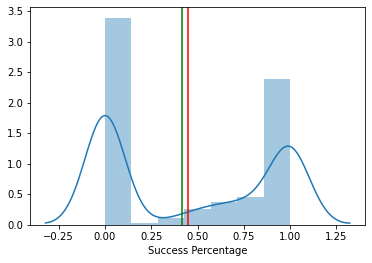

In [36]:
sns.distplot(climb_rainier['Success Percentage'])
plt.axvline(climb_rainier['Success Percentage'].mean(), color='red')
plt.axvline(climb_rainier['Success Percentage'].median(), color='green')
plt.show()

In [37]:
climb_rainier['Date'] = pd.to_datetime(climb_rainier['Date'])

In [40]:
climb_rainier['Date'].tail(200)

1695   2015-05-19
1696   2015-05-18
1697   2015-05-18
1698   2015-05-18
1699   2015-05-18
          ...    
1890   2014-09-26
1891   2014-09-25
1892   2014-09-25
1893   2014-09-24
1894   2014-09-23
Name: Date, Length: 200, dtype: datetime64[ns]

In [53]:
climb_rainier.head(200)

,Date,Route,Attempted,Succeeded,Success Percentage,Battery Voltage AVG,Temperature AVG,Relative Humidity AVG,Wind Speed Daily AVG,Wind Direction AVG,Solare Radiation AVG
0,2015-11-27,disappointment cleaver,2,0,0.000000,13.643750,26.321667,19.715000,27.839583,68.004167,88.496250
1,2015-11-21,disappointment cleaver,3,0,0.000000,13.749583,31.300000,21.690708,2.245833,117.549667,93.660417
2,2015-10-15,disappointment cleaver,2,0,0.000000,13.461250,46.447917,27.211250,17.163625,259.121375,138.387000
3,2015-10-13,little tahoma,8,0,0.000000,13.532083,40.979583,28.335708,19.591167,279.779167,176.382667
4,2015-10-09,disappointment cleaver,2,0,0.000000,13.216250,38.260417,74.329167,65.138333,264.687500,27.791292
...,...,...,...,...,...,...,...,...,...,...,...
197,2015-08-19,disappointment cleaver,2,0,0.000000,13.410417,51.189583,24.261667,2.924458,185.827917,291.301667
198,2015-08-19,Other,2,2,1.000000,13.410417,51.189583,24.261667,2.924458,185.827917,291.301667
199,2015-08-19,disappointment cleaver,12,5,0.416667,13.410417,51.189583,24.261667,2.924458,185.827917,291.301667
200,2015-08-19,disappointment cleaver,11,4,0.363636,13.410417,51.189583,24.261667,2.924458,185.827917,291.301667


In [55]:
train = climb_rainier[climb_rainier['Date'] < '2015-08-20']
test = climb_rainier[climb_rainier['Date'] >= '2015-08-20']

In [56]:
train.shape, test.shape

((1694, 11), (195, 11))

In [61]:
train['Success Percentage'].mean()

0.4674534176280992

In [62]:
target = 'Success Percentage'
y_train = train[target]
y_test = test[target]

In [63]:
# mean baseline
guess = y_train.mean()
# guess
print(f'Mean baseline with 0 features is: {guess:.3f}')

Mean baseline with 0 features is: 0.467


In [64]:
# Train Error
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
y_pred = [guess] * len(y_train)
mae = mean_absolute_error(y_train, y_pred)
mae

0.44120789757032597

In [71]:
train.drop([target], axis=1).columns.to_list()

['Date',
 'Route',
 'Attempted',
 'Succeeded',
 'Battery Voltage AVG',
 'Temperature AVG',
 'Relative Humidity AVG',
 'Wind Speed Daily AVG',
 'Wind Direction AVG',
 'Solare Radiation AVG']

In [77]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

# feature matrices
features = train.drop([target, 'Date', 'Route'], axis=1).columns.to_list()
X_train = train[features]
X_test = test[features]

# fit the model
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [78]:
# train Error
y_pred = model.predict(X_train)
mae = mean_absolute_error(y_train, y_pred)
print('Train Mean absolute error:', mae)

Train Mean absolute error: 0.2414650882829599


In [79]:
# test error
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print('Test Mean absolute error:', mae)

Test Mean absolute error: 0.2770134964173807
